## Descrição geral do dataset

O dataset contém dados históricos de vendas diários fornecido por uma empresa de software Russa - 1C Company. A tarefa é prever a quantidade total de produtos vendidos em cada loja para o conjunto de teste. Observe que a lista de lojas e produtos muda ligeiramente a cada mês. Criar um modelo robusto que possa lidar com tais situações é parte do desafio.

## Descrição das variáveis do dataset:

ID - an Id that represents a (Shop, Item) tuple within the test set

shop_id - unique identifier of a shop

item_id - unique identifier of a product

item_category_id - unique identifier of item category

date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

date - date in format dd/mm/yyyy

item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

item_price - current price of an item

item_name - name of item

shop_name - name of shop

item_category_name - name of item category

### Importando as bibliotecas necessárias

In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

### Carregando os datasets

In [2]:
test = pd.read_csv('~/Documents/Kaggle/Predict Sales/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})
item_categories = pd.read_csv('~/Documents/Kaggle/Predict Sales/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('~/Documents/Kaggle/Predict Sales/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
shops = pd.read_csv('~/Documents/Kaggle/Predict Sales/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
sales = pd.read_csv('~/Documents/Kaggle/Predict Sales/sales_train.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

#### Combinando os datasets

In [3]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [5]:
print('Train linhas: ', train.shape[0])
print('Train colunas: ', train.shape[1])

Train linhas:  2935849
Train colunas:  10


In [6]:
train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-02-01               0       59    22154      999.00             1   
1 2013-03-01               0       25     2552      899.00             1   
2 2013-05-01               0       25     2552      899.00            -1   
3 2013-06-01               0       25     2554     1709.05             1   
4 2013-01-15               0       25     2555     1099.00             1   

                                  item_name  item_category_id  \
0                         ЯВЛЕНИЕ 2012 (BD)                37   
1  DEEP PURPLE  The House Of Blue Light  LP                58   
2  DEEP PURPLE  The House Of Blue Light  LP                58   
3  DEEP PURPLE  Who Do You Think We Are  LP                58   
4   DEEP PURPLE 30 Very Best Of 2CD (Фирм.)                56   

                shop_name                   item_category_name  
0  Ярославль ТЦ "Альтаир"                       Кино - Blu-Ray  
1     Москва ТРК "Атриум"                       Музыка - Винил  
2     Москва ТРК "Атриум"                       Музыка - Винил  
3     Москва ТРК "Атриум"                       Музыка - Винил  
4     Москва ТРК "Атриум"  Музыка - CD фирменного производства

In [7]:
train.describe()

date_block_num    shop_id    item_id  item_price  item_cnt_day  \
count      2935849.00 2935849.00 2935849.00  2935849.00    2935849.00   
mean            14.57      33.00   10197.23      890.85          1.24   
std              9.42      16.23    6324.30     1729.80          2.62   
min              0.00       0.00       0.00       -1.00        -22.00   
25%              7.00      22.00    4476.00      249.00          1.00   
50%             14.00      31.00    9343.00      399.00          1.00   
75%             23.00      47.00   15684.00      999.00          1.00   
max             33.00      59.00   22169.00   307980.00       2169.00   

       item_category_id  
count        2935849.00  
mean              40.00  
std               17.10  
min                0.00  
25%               28.00  
50%               40.00  
75%               55.00  
max               83.00

In [8]:
print('Data mínima da base de treino: %s' % train['date'].min().date())
print('Data máxima da base de treino: %s' % train['date'].max().date())

Data mínima da base de treino: 2013-01-01
Data máxima da base de treino: 2015-12-10


### Data leakages

Para evitar problemas com dados inconsistentes entre a base de treino e teste será utlizado apenas os dados de shop_id e item_id que existem na base de teste

In [4]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
# Somente lojas que existem na base de teste
lk_train = train[train['shop_id'].isin(test_shop_ids)]
# Somente itens que existem na base de teste
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]

In [10]:
print('Tamanho do dataset antes do leaking:', train.shape[0])
print('Tamanho do dataset após o leaking:', lk_train.shape[0])
print('Diferença de:', train.shape[0]-lk_train.shape[0],'linhas')

Tamanho do dataset antes do leaking: 2935849
Tamanho do dataset após o leaking: 1224439
Diferença de: 1711410 linhas


### Data cleaning

Somente itens com preço maior que 0

In [5]:
train = train.query('item_price > 0')

### Data preprocessing

Removi colunas de texto, pois não serão utilizadas

In [6]:
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]

In [7]:
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly.head()

date  date_block_num  shop_id  item_category_id  item_id  \
57119   2013-01-01               0       14                30     2808   
16686   2013-01-01               0       28                55    10928   
16290   2013-01-01               0       28                19    13511   
15689   2013-01-01               0       28                 5     5583   
15680   2013-01-01               0       28                 2     5572   
...            ...             ...      ...               ...      ...   
2893291 2015-12-10              33       38                40    17775   
2893289 2015-12-10              33       38                37    17774   
2893275 2015-12-10              33       38                55    18511   
2893265 2015-12-10              33       38                55    18439   
2887937 2015-12-10              33       42                40     7712   

         item_price  item_cnt_day  
57119        999.00             2  
16686        199.00             1  
16290       1598.75             2  
15689        699.00             1  
15680       1590.00             1  
...             ...           ...  
2893291      399.00             1  
2893289      749.00             1  
2893275      229.00             1  
2893265      229.00             1  
2887937      149.00             1  

[1075034 rows x 7 columns]

Agrupei por mês (date_clock_num) e agreguei por soma, media e contagem.

In [8]:
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})

Renomeei as colunas

In [9]:
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price',
                         'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [16]:
train_monthly.head()

date_block_num  shop_id  item_category_id  item_id  item_price  \
0               0        2                 2     5572    10730.00   
1               0        2                 2     5643     4775.21   
2               0        2                 5     5583     1188.30   
3               0        2                 6     7893     5970.00   
4               0        2                 6     7894     1490.00   

   mean_item_price  item_cnt  mean_item_cnt  transactions  
0          1532.86         9           1.29             7  
1          2387.60         0           0.00             2  
2           594.15         2           1.00             2  
3          1990.00         3           1.00             3  
4          1490.00         1           1.00             1

Para imitar o comportamento real dos dados, temos que criar os valores ausentes do conjunto de dados carregado. Então, para cada mês, foi criado valores ausentes para cada loja e item. Como não temos dados para eles, foram substituidos por zero.

Criei um dataset com todas as possíveis combinações de ['date_block_num','shop_id','item_id'] para não ter valores faltantes

In [10]:
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()

empty_df = []
for i in range(34): # numero de meses - date_block_num - de 0 a 33
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])
    
empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])

In [18]:
pd.set_option('display.max_rows', 100)
empty_df.head()

date_block_num  shop_id  item_id
0               0        2     5572
1               0        2     5643
2               0        2     5583
3               0        2     7893
4               0        2     7894

Combinei a base de treino com a base completa (valores ausentes serão preenchidos com zero).

In [11]:
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

#### Verificando como ficou o dataset:

In [20]:
train_monthly

date_block_num  shop_id  item_id  item_category_id  item_price  \
0                     0        2     5572              2.00    10730.00   
1                     0        2     5643              2.00     4775.21   
2                     0        2     5583              5.00     1188.30   
3                     0        2     7893              6.00     5970.00   
4                     0        2     7894              6.00     1490.00   
...                 ...      ...      ...               ...         ...   
6734443              33       36     9103              0.00        0.00   
6734444              33       36     9107              0.00        0.00   
6734445              33       36     5704              0.00        0.00   
6734446              33       36    12733              0.00        0.00   
6734447              33       36    15925              0.00        0.00   

         mean_item_price  item_cnt  mean_item_cnt  transactions  
0                1532.86      9.00           1.29          7.00  
1                2387.60      0.00           0.00          2.00  
2                 594.15      2.00           1.00          2.00  
3                1990.00      3.00           1.00          3.00  
4                1490.00      1.00           1.00          1.00  
...                  ...       ...            ...           ...  
6734443             0.00      0.00           0.00          0.00  
6734444             0.00      0.00           0.00          0.00  
6734445             0.00      0.00           0.00          0.00  
6734446             0.00      0.00           0.00          0.00  
6734447             0.00      0.00           0.00          0.00  

[6734448 rows x 9 columns]

In [21]:
train_monthly.describe().T

count     mean     std   min     25%      50%      75%  \
date_block_num   6734448.00    16.50    9.81  0.00    8.00    16.50    25.00   
shop_id          6734448.00    31.64   17.56  2.00   16.00    34.50    47.00   
item_id          6734448.00 11041.89 6210.74 30.00 5385.25 11265.50 16068.25   
item_category_id 6734448.00     3.79   13.21  0.00    0.00     0.00     0.00   
item_price       6734448.00   187.39 2177.44  0.00    0.00     0.00     0.00   
mean_item_price  6734448.00    81.23  534.73  0.00    0.00     0.00     0.00   
item_cnt         6734448.00     0.24    3.46 -4.00    0.00     0.00     0.00   
mean_item_cnt    6734448.00     0.10    0.61 -2.00    0.00     0.00     0.00   
transactions     6734448.00     0.18    0.90  0.00    0.00     0.00     0.00   

                       max  
date_block_num       33.00  
shop_id              59.00  
item_id           22167.00  
item_category_id     83.00  
item_price       515573.59  
mean_item_price   42990.00  
item_cnt           2253.00  
mean_item_cnt      1000.00  
transactions         31.00

Extrai o mês e o ano. 

Existem 34 meses, que correspondem a 2 anos e 10 meses (entre jan/2013 e out/2015).

In [12]:
# Dividindo por 12 sem restos e somando 2013
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))

# Dividindo por 12 e obtendo o resto
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

### Analise Exploratória

#### Agrupando os dados para Analise Exploratória.

In [13]:
# Obtendo a média e soma dos itens vendidos
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()

# Obtendo a média e soma das categorias vendidos
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()

# Obtendo a média e soma das lojas
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

#### Visualização das vendas por mês, categoria e lojas

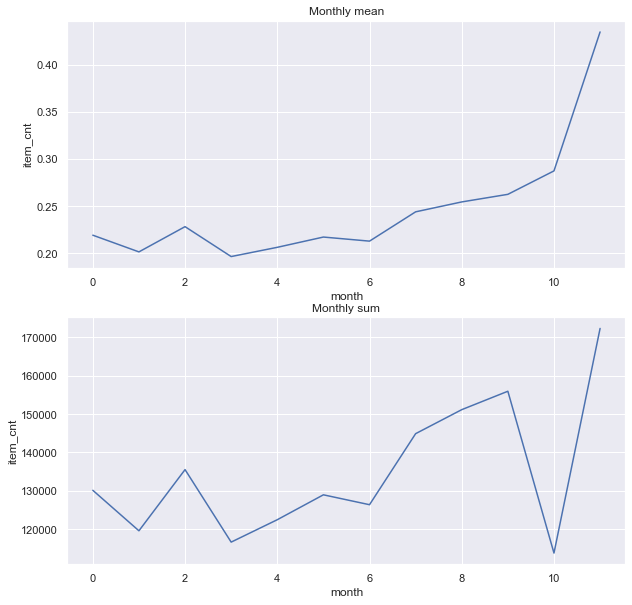

In [14]:
f, axes = plt.subplots(2, 1, figsize=(10, 10))
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

De acordo com os gráficos acima, as vendas aumentam ao longo do ano e disparam próximo do final do ano. Com uma pequena elevação nas vendas no mês de março.

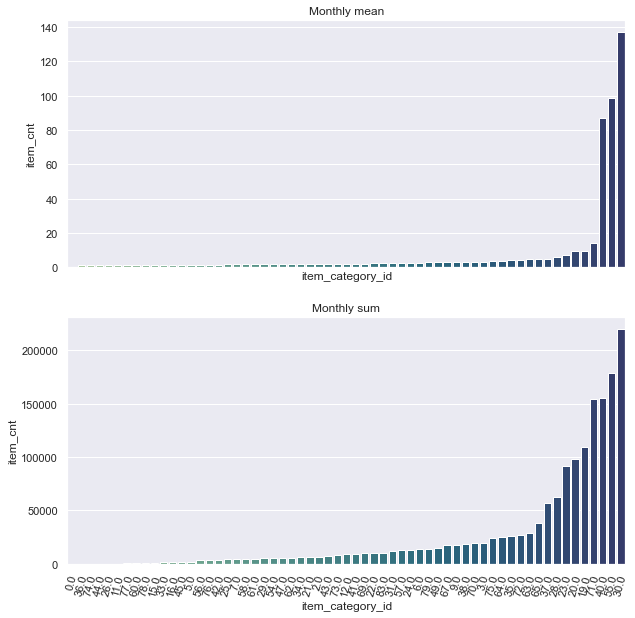

In [15]:
f, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="crest", order=gp_category_mean.sort_values('item_cnt').item_category_id).set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="crest", order=gp_category_sum.sort_values('item_cnt').item_category_id).set_title("Monthly sum")
plt.xticks(rotation=75)
plt.show()

Na média mensal, três categorias possuem a maior parte dos itens vendidos.

Na soma mensal, a distribuição fica menos assimetríca, porém em torno de 9 categorias possuem a maior parte dos itens vendidos.

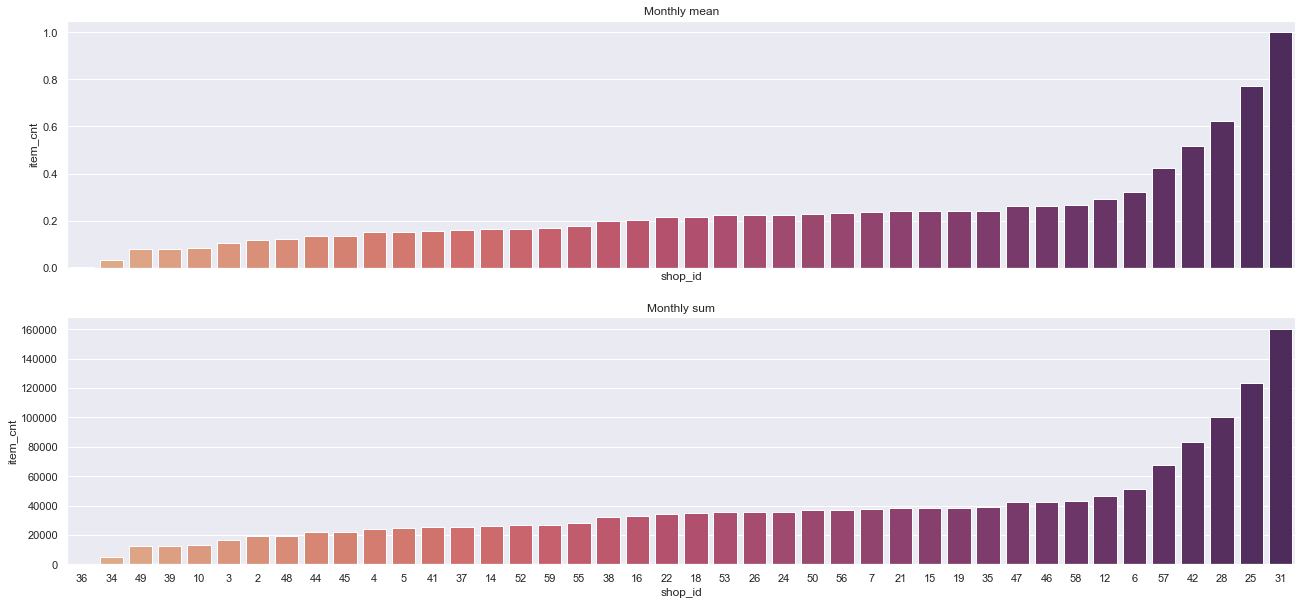

In [26]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="flare", order=gp_shop_mean.sort_values('item_cnt').shop_id).set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="flare", order=gp_shop_sum.sort_values('item_cnt').shop_id).set_title("Monthly sum")
plt.show()

Três loja apresentam maior numero de itens vendidos mensalmente (Id: 31, 25, 28)

A maior parte possui taxa de vendas semelhantes.

Seis lojas apresentam taxa de venda mensal menor que 20.000.

### Procurando outliers¶

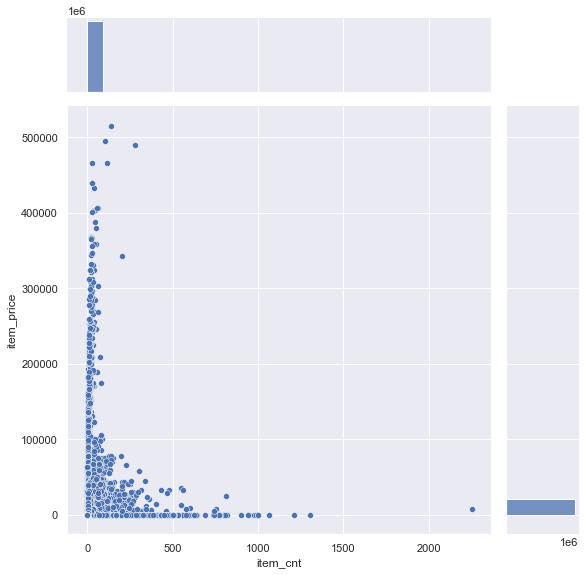

In [27]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

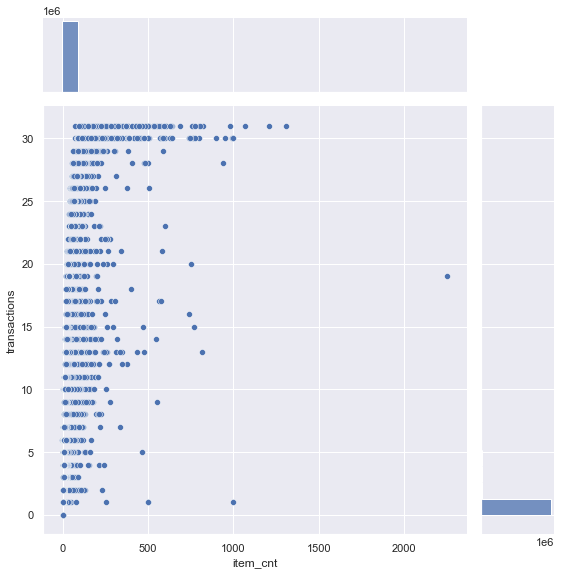

In [16]:
sns.jointplot(x="item_cnt", y="transactions", data=train_monthly, height=8)
plt.show()

In [ ]:
train_monthly

<AxesSubplot:xlabel='item_cnt'>

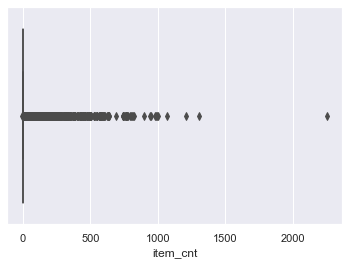

In [17]:
sns.boxplot(x="item_cnt", data=train_monthly)

<AxesSubplot:xlabel='item_price'>

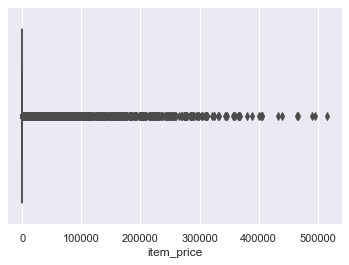

In [18]:
sns.boxplot(x="item_price", data=train_monthly)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(0, 0, '0.0'),
  Text(1, 0, '1.0'),
  Text(2, 0, '2.0'),
  Text(3, 0, '3.0'),
  Text(4, 0, '4.0'),
  Text(5, 0, '5.0'),
  Text(6, 0, '6.0'),
  Text(7, 0, '7.0'),
  Text(8, 0, '8.0'),
  Text(9, 0, '9.0'),
  Text(10, 0, '10.0'),
  Text(11, 0, '11.0'),
  Text(12, 0, '12.0'),
  Text(13, 0, '13.0'),
  Text(14, 0, '14.0'),
  Text(15, 0, '15.0'),
  Text(16, 0, '16.0'),
  Text(17, 0, '17.0'),
  Text(18, 0, '18.0'),
  Text(19, 0, '19.0'),
  Text(20, 0, '20.0'),
  Text(21, 0, '21.0'),
  Text(22, 0, '22.0'),
  Text(23, 0, '23.0'),
  Text(24, 0, '24.0'),
  Text(25, 0, '25.0'),
  Text(26, 0, '26.0'),
  Text(27, 0, '27.0'),
  Text(28, 0, '28.0'),
  Text(29, 0, '29.0'),
  Text(30, 0, '30.0'),
  Text(31, 0, '31.0')])

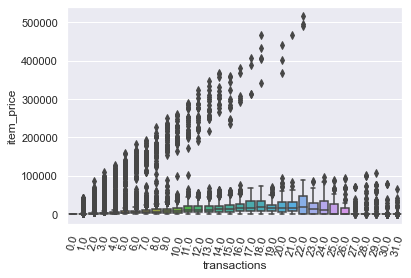

In [19]:
sns.boxplot(x="transactions", y="item_price", data=train_monthly)
plt.xticks(rotation=75)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(0, 0, '0.0'),
  Text(1, 0, '1.0'),
  Text(2, 0, '2.0'),
  Text(3, 0, '3.0'),
  Text(4, 0, '4.0'),
  Text(5, 0, '5.0'),
  Text(6, 0, '6.0'),
  Text(7, 0, '7.0'),
  Text(8, 0, '8.0'),
  Text(9, 0, '9.0'),
  Text(10, 0, '10.0'),
  Text(11, 0, '11.0'),
  Text(12, 0, '12.0'),
  Text(13, 0, '13.0'),
  Text(14, 0, '14.0'),
  Text(15, 0, '15.0'),
  Text(16, 0, '16.0'),
  Text(17, 0, '17.0'),
  Text(18, 0, '18.0'),
  Text(19, 0, '19.0'),
  Text(20, 0, '20.0'),
  Text(21, 0, '21.0'),
  Text(22, 0, '22.0'),
  Text(23, 0, '23.0'),
  Text(24, 0, '24.0'),
  Text(25, 0, '25.0'),
  Text(26, 0, '26.0'),
  Text(27, 0, '27.0'),
  Text(28, 0, '28.0'),
  Text(29, 0, '29.0'),
  Text(30, 0, '30.0'),
  Text(31, 0, '31.0')])

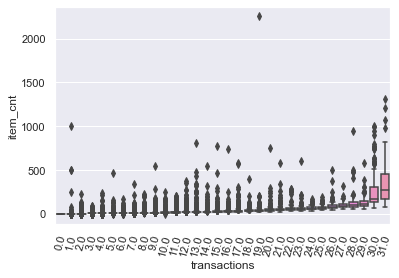

In [20]:
sns.boxplot(x="transactions", y="item_cnt", data=train_monthly)
plt.xticks(rotation=75)

#### Removendo Outliers

Removi item_cnt menor que 0 e maior que 20 (Seção Evaluation diz que os valores de testes estão cortados no intervalo (0,20)) e item_price maior que 400.000

In [21]:
train_monthly = train_monthly.query("item_cnt >= 0 and item_price < 400000")
#and item_cnt <= 20 

#### Criando a variável resposta

Para cada mês será obtido o item_cnt do próximo mês

In [22]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

In [ ]:
train_monthly

### Feature engineering


##### Criando coluna de preço unitário.

In [23]:
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
pd.set_option('use_inf_as_na', True)
train_monthly['item_price_unit'].fillna(0, inplace=True)

##### Variáveis baseadas em agrupamentos

In [24]:
# item_price minimo e maximo para cada item_id
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

# combinando com o dataset completo
train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')
train_monthly.head()

date_block_num  shop_id  item_id  item_category_id  item_price  \
0               0        2     5572              2.00    10730.00   
1               0        2     5643              2.00     4775.21   
2               0        2     5583              5.00     1188.30   
3               0        2     7893              6.00     5970.00   
4               0        2     7894              6.00     1490.00   

   mean_item_price  item_cnt  mean_item_cnt  transactions  year  month  \
0          1532.86      9.00           1.29          7.00  2013      0   
1          2387.60      0.00           0.00          2.00  2013      0   
2           594.15      2.00           1.00          2.00  2013      0   
3          1990.00      3.00           1.00          3.00  2013      0   
4          1490.00      1.00           1.00          1.00  2013      0   

   item_cnt_month  item_price_unit  hist_min_item_price  hist_max_item_price  
0            1.00          1192.00                 0.00             18979.50  
1            0.00             0.00                 0.00             35260.00  
2            1.00           594.00                 0.00              5592.00  
3            2.00          1990.00                 0.00             42630.00  
4            2.00          1490.00                 0.00             31290.00

##### Aumento e redução em relação ao preços históricos mínimo e maximo

In [ ]:
#train_monthly.drop(['hist_max_item_price_x', 'hist_min_item_price_x', 'hist_min_item_price_y', 'hist_max_item_price_y'], axis=1, inplace=True)

##### Variáveis baseadas em janelas de 3 meses antecedentes (window = 3 meses).


In [25]:
# Valor mínimo
f_min = lambda x: x.rolling(window=3, min_periods=1).min()

# Valor máximo
f_max = lambda x: x.rolling(window=3, min_periods=1).max()

# Valor médio
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()

# Desvio Padrão
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Preencha com zero os NA's em item_cnt_std
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [ ]:
train_monthly.head()

##### Variáveis lags

In [26]:
lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    
    # Preencha com zero os NA's das variáveis lags
    train_monthly[ft_name].fillna(0, inplace=True)

##### Criei item_trend. 
Medida que corresponde a magnitude da mudança de item_cnt para as variaveis item_cnt_shifted 1,2 e 3


In [27]:
train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1 # dividido por 4, 3 lags mais o periodo normal

In [28]:
train_monthly.head().T

0        1       2        3        4
date_block_num          0.00     0.00    0.00     0.00     0.00
shop_id                 2.00     2.00    2.00     2.00     2.00
item_id              5572.00  5643.00 5583.00  7893.00  7894.00
item_category_id        2.00     2.00    5.00     6.00     6.00
item_price          10730.00  4775.21 1188.30  5970.00  1490.00
mean_item_price      1532.86  2387.60  594.15  1990.00  1490.00
item_cnt                9.00     0.00    2.00     3.00     1.00
mean_item_cnt           1.29     0.00    1.00     1.00     1.00
transactions            7.00     2.00    2.00     3.00     1.00
year                 2013.00  2013.00 2013.00  2013.00  2013.00
month                   0.00     0.00    0.00     0.00     0.00
item_cnt_month          1.00     0.00    1.00     2.00     2.00
item_price_unit      1192.00     0.00  594.00  1990.00  1490.00
hist_min_item_price     0.00     0.00    0.00     0.00     0.00
hist_max_item_price 18979.50 35260.00 5592.00 42630.00 31290.00
item_cnt_min            9.00     0.00    2.00     3.00     1.00
item_cnt_max            9.00     0.00    2.00     3.00     1.00
item_cnt_mean           9.00     0.00    2.00     3.00     1.00
item_cnt_std            0.00     0.00    0.00     0.00     0.00
item_cnt_shifted1       0.00     0.00    0.00     0.00     0.00
item_cnt_shifted2       0.00     0.00    0.00     0.00     0.00
item_cnt_shifted3       0.00     0.00    0.00     0.00     0.00
item_trend              2.25     0.00    0.50     0.75     0.25

In [29]:
train_monthly.describe().T

count     mean      std     min     25%      50%  \
date_block_num      6734185.00    16.50     9.81    0.00    8.00    16.00   
shop_id             6734185.00    31.64    17.56    2.00   16.00    35.00   
item_id             6734185.00 11041.98  6210.74   30.00 5386.00 11266.00   
item_category_id    6734185.00     3.79    13.21    0.00    0.00     0.00   
item_price          6734185.00   186.58  2100.22    0.00    0.00     0.00   
mean_item_price     6734185.00    81.12   533.23    0.00    0.00     0.00   
item_cnt            6734185.00     0.24     3.45    0.00    0.00     0.00   
mean_item_cnt       6734185.00     0.10     0.61    0.00    0.00     0.00   
transactions        6734185.00     0.18     0.90    0.00    0.00     0.00   
year                6734185.00  2013.94     0.80 2013.00 2013.00  2014.00   
month               6734185.00     5.21     3.32    0.00    2.00     5.00   
item_cnt_month      6536113.00     0.24     3.50    0.00    0.00     0.00   
item_price_unit     6734185.00    77.03   506.55    0.00    0.00     0.00   
hist_min_item_price 6734185.00     0.00     0.00    0.00    0.00     0.00   
hist_max_item_price 6734185.00  6337.69 13925.16   45.00 1047.00  2495.00   
item_cnt_min        6734185.00     0.18     2.62    0.00    0.00     0.00   
item_cnt_max        6734185.00     0.36     4.52    0.00    0.00     0.00   
item_cnt_mean       6734185.00     0.26     3.33    0.00    0.00     0.00   
item_cnt_std        6734185.00     0.10     1.55    0.00    0.00     0.00   
item_cnt_shifted1   6734185.00     0.22     3.31    0.00    0.00     0.00   
item_cnt_shifted2   6734185.00     0.19     3.25    0.00    0.00     0.00   
item_cnt_shifted3   6734185.00     0.18     3.22    0.00    0.00     0.00   
item_trend          6734185.00    -0.09     1.67 -636.00    0.00     0.00   

                         75%       max  
date_block_num         25.00     33.00  
shop_id                47.00     59.00  
item_id             16069.00  22167.00  
item_category_id        0.00     83.00  
item_price              0.00 388163.34  
mean_item_price         0.00  42990.00  
item_cnt                0.00   2253.00  
mean_item_cnt           0.00   1000.00  
transactions            0.00     31.00  
year                 2015.00   2015.00  
month                   8.00     11.00  
item_cnt_month          0.00   2253.00  
item_price_unit         0.00  94970.00  
hist_min_item_price     0.00      0.00  
hist_max_item_price  5996.00 388163.34  
item_cnt_min            0.00    978.00  
item_cnt_max            0.00   2253.00  
item_cnt_mean           0.00   1090.67  
item_cnt_std            0.00   1211.13  
item_cnt_shifted1       0.00   1305.00  
item_cnt_shifted2       0.00   1305.00  
item_cnt_shifted3       0.00   1305.00  
item_trend              0.00    432.75

### Train/validation split

Como a base de teste está no futuro, tentarei simular a mesma distribuição na base de treino.

A base de treino irá do 3 ao 28 bloco de data (mês) - devido ao uso de variável de janela de 3 meses, logo não serão úteis. 

A base de validação serão os bloco de data 29 até 32.

A base de teste será o bloco 33 (que contará como o bloco 34 pois a variavel resposta foi criada com 1 mês de adiantamento).

In [32]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

print('Formato da base de treino:', train_set.shape[0])
print('Formato da base de validação:', validation_set.shape[0])
print('Formato da base de teste:', test_set.shape[0])

print('Base de treino: %s (%.f%% of complete data)' % (train_set.shape[0], ((train_set.shape[0]/train_monthly.shape[0])*100)))
print('Base de validação: %s (%.f%% of complete data)' % (validation_set.shape[0], ((validation_set.shape[0]/train_monthly.shape[0])*100)))

Formato da base de treino: 4951610
Formato da base de validação: 990296
Formato da base de teste: 198064
Base de treino: 4951610 (74% of complete data)
Base de validação: 990296 (15% of complete data)


##### Mean Enconding

In [33]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)

# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)

# Shop com item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)

# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)

# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)

# Adicionando variáveis mean enconding a base de treino.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')

# Adicionando variáveis mean enconding a base de validação.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [196]:
X_train.head()

shop_id  item_id  item_price  mean_item_price  item_cnt  mean_item_cnt  \
0        2     5572     2980.00          1490.00      2.00           1.00   
1        2     5643        0.00             0.00      0.00           0.00   
2        2     5583        0.00             0.00      0.00           0.00   
3        2     7893     9350.00          1870.00      5.00           1.00   
4        2     7894        0.00             0.00      0.00           0.00   

   transactions  year  month  item_price_unit  ...  item_cnt_std  \
0          2.00  2013      3          1490.00  ...          0.58   
1          0.00  2013      3             0.00  ...          0.00   
2          0.00  2013      3             0.00  ...          0.00   
3          5.00  2013      3          1870.00  ...          2.08   
4          0.00  2013      3             0.00  ...          0.00   

   item_cnt_shifted1  item_cnt_shifted2  item_cnt_shifted3  item_trend  \
0               1.00               1.00               9.00       -2.25   
1               0.00               0.00               0.00        0.00   
2               0.00               0.00               0.00        0.00   
3               1.00               2.00               3.00       -0.25   
4               0.00               0.00               0.00        0.00   

   shop_mean  item_mean  shop_item_mean  year_mean  month_mean  
0       0.10       1.00            0.84       0.14        0.16  
1       0.10       1.82            1.84       0.14        0.16  
2       0.10       0.59            0.04       0.14        0.16  
3       0.10       3.04            3.12       0.14        0.16  
4       0.10       3.67            1.68       0.14        0.16  

[5 rows x 25 columns]

##### Criando base de treino e validação, e as respectivas variaveis respostas 

In [97]:
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)

Y_train = train_set['item_cnt_month'].astype(int)

X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)

Y_validation = validation_set['item_cnt_month'].astype(int)

##### Passando variáveis numéricas de float64 para int32.

In [98]:
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

##### Construindo a base de teste

Como a variável resposta reflete o valor para o mês seguinte, será utilizado o bloco 33 (Ano 2015, mês 9 - corresponde a outubro pq começa em 0 a contagem) para prever o mês 34.

In [52]:
X_train.columns

Index(['shop_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt',
       'mean_item_cnt', 'transactions', 'year', 'month', 'item_price_unit',
       'hist_min_item_price', 'hist_max_item_price', 'item_cnt_min',
       'item_cnt_max', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
       'item_cnt_shifted2', 'item_cnt_shifted3', 'item_trend', 'shop_mean',
       'item_mean', 'shop_item_mean', 'year_mean', 'month_mean'],
      dtype='object')

In [51]:
train_validation = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, train_validation, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

##### Substituindo os NA's pela mediana de cada loja.   


In [99]:
sets = [X_train, X_validation, X_test]

for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median
            
# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [ ]:
X_test.head().T

##### Passando variáveis numéricas de float64 para int32 novamente

In [101]:
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')
X_test[int_features] = X_test[int_features].astype('int32')

##### Removi "item_category_id" por que não existe na base de teste.

In [102]:
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

KeyError: "['item_category_id'] not found in axis"

##### Conferindo como ficou a base de teste e obtendo estatistcas descritivas

In [56]:
X_test.head()

shop_id  item_id  item_price  mean_item_price  item_cnt  mean_item_cnt  \
0        5     5037      749.50           749.50      1.00           1.00   
1        5     5320        0.00             0.00      0.00           0.00   
2        5     5233     2997.00           999.00      3.00           1.00   
3        5     5232        0.00             0.00      0.00           0.00   
4        5     5268        0.00             0.00      0.00           0.00   

   transactions  year  month  item_price_unit  ...  item_cnt_std  \
0          1.00  2015      9           749.00  ...          1.15   
1          0.00  2015      9             0.00  ...          0.00   
2          3.00  2015      9           999.00  ...          1.00   
3          0.00  2015      9             0.00  ...          0.00   
4          0.00  2015      9             0.00  ...          0.00   

   item_cnt_shifted1  item_cnt_shifted2  item_cnt_shifted3  item_trend  \
0               3.00               1.00               1.00       -1.00   
1               0.00               0.00               0.00        0.00   
2               1.00               2.00               3.00       -0.75   
3               0.00               0.00               0.00        0.00   
4               0.00               0.00               0.00        0.00   

   shop_mean  item_mean  shop_item_mean  year_mean  month_mean  
0       0.16       0.70            0.28       0.28        0.23  
1       0.16       0.06            0.00       0.28        0.23  
2       0.16       0.07            0.12       0.28        0.23  
3       0.16       0.00            0.00       0.28        0.23  
4       0.16       0.06            0.00       0.28        0.23  

[5 rows x 25 columns]

In [57]:
X_test.describe().T

count     mean      std     min     25%      50%  \
shop_id             214200.00    31.64    17.56    2.00   16.00    34.50   
item_id             214200.00 11019.40  6252.64   30.00 5381.50 11203.00   
item_price          214200.00   256.47  2024.81    0.00    0.00     0.00   
mean_item_price     214200.00   135.51   869.72    0.00    0.00     0.00   
item_cnt            214200.00     0.27     2.50    0.00    0.00     0.00   
mean_item_cnt       214200.00     0.14     0.42    0.00    0.00     0.00   
transactions        214200.00     0.21     0.85    0.00    0.00     0.00   
year                214200.00  2015.00     0.00 2015.00 2015.00  2015.00   
month               214200.00     9.00     0.00    9.00    9.00     9.00   
item_price_unit     214200.00   127.45   834.02    0.00    0.00     0.00   
hist_min_item_price 214200.00     0.00     0.00    0.00    0.00     0.00   
hist_max_item_price 214200.00  6049.42 13439.93   45.00 1196.00  2495.00   
item_cnt_min        214200.00     0.22     2.07    0.00    0.00     0.00   
item_cnt_max        214200.00     0.38     2.82    0.00    0.00     0.00   
item_cnt_mean       214200.00     0.29     2.37    0.00    0.00     0.00   
item_cnt_std        214200.00     0.09     0.72    0.00    0.00     0.00   
item_cnt_shifted1   214200.00     0.24     2.13    0.00    0.00     0.00   
item_cnt_shifted2   214200.00     0.20     2.14    0.00    0.00     0.00   
item_cnt_shifted3   214200.00     0.20     2.29    0.00    0.00     0.00   
item_trend          214200.00    -0.09     1.12 -219.75    0.00     0.00   
shop_mean           214200.00     0.25     0.19    0.00    0.16     0.22   
item_mean           214200.00     0.24     1.91    0.00    0.01     0.06   
shop_item_mean      214200.00     0.23     2.83    0.00    0.00     0.00   
year_mean           214200.00     0.28     0.00    0.28    0.28     0.28   
month_mean          214200.00     0.23     0.00    0.23    0.23     0.23   

                         75%       max  
shop_id                47.00     59.00  
item_id             16071.50  22167.00  
item_price              0.00 166944.50  
mean_item_price         0.00  32990.00  
item_cnt                0.00    473.00  
mean_item_cnt           0.00     36.50  
transactions            0.00     30.00  
year                 2015.00   2015.00  
month                   9.00      9.00  
item_price_unit         0.00  32990.00  
hist_min_item_price     0.00      0.00  
hist_max_item_price  5593.00 388163.34  
item_cnt_min            0.00    436.00  
item_cnt_max            0.00    482.00  
item_cnt_mean           0.00    463.67  
item_cnt_std            0.00     93.96  
item_cnt_shifted1       0.00    436.00  
item_cnt_shifted2       0.00    482.00  
item_cnt_shifted3       0.00    444.00  
item_trend              0.00     36.50  
shop_mean               0.25      1.04  
item_mean               0.19    129.94  
shop_item_mean          0.12    706.60  
year_mean               0.28      0.28  
month_mean              0.23      0.23

### Modeling

##### - Modelos Baseados em Árvores

#### Catboost

In [103]:
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_validation, Y_validation)
)

Learning rate set to 0.354271
0:	learn: 3.0078386	test: 2.8884368	best: 2.8884368 (0)	total: 2.36s	remaining: 19m 35s
50:	learn: 1.7517143	test: 2.4543699	best: 2.4543699 (50)	total: 1m 46s	remaining: 15m 40s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 2.428689279
bestIteration = 66

Shrink model to first 67 iterations.


In [104]:
print('Model params:', catboost_model.get_params())

Model params: {'iterations': 500, 'depth': 4, 'loss_function': 'RMSE', 'od_wait': 25, 'od_type': 'Iter', 'random_seed': 0, 'verbose': 50, 'max_ctr_complexity': 4}


##### Catboost feature importance

Criando um Data Frame com os valores de importancia para cada coluna do dataset X_train.

Depois plotei o gráfico.


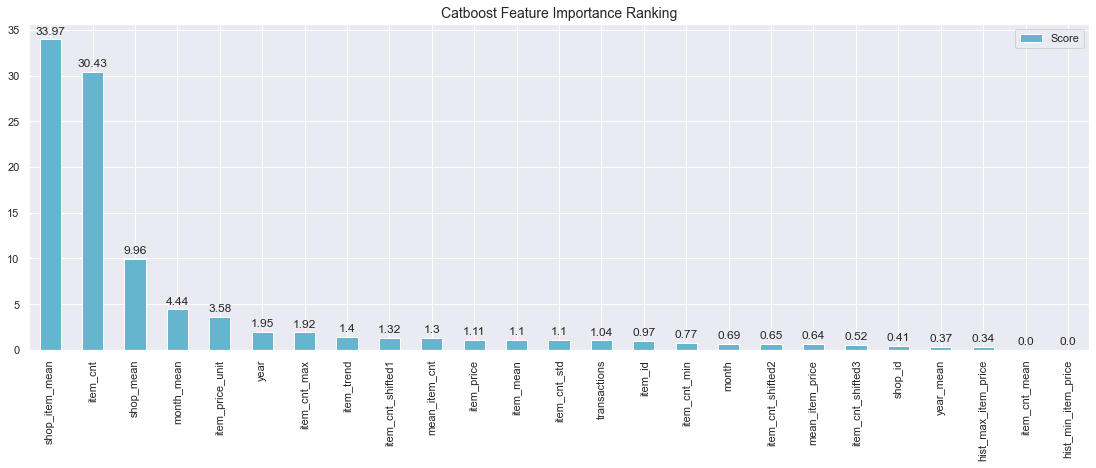

In [105]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=Y_train, cat_features=cat_features)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

# Colocando o texto com os scores em cima de cada barra
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

As variáveis que mais contribuiram para o modelo Catboost foram:
- shop_item_mean
- item_cnt
- shop_mean

In [106]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

In [107]:
print('Base de Treino RMSE:', np.sqrt(mean_squared_error(Y_train, catboost_train_pred)))
print('Base de Validação RMSE:', np.sqrt(mean_squared_error(Y_validation, catboost_val_pred)))

Base de Treino RMSE: 1.7159661164062803
Base de Validação RMSE: 2.4286892787693986


#### XG Boost

##### Criando base de treino, validação e teste

In [108]:
# Usando apenas parte das variáveis
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

##### Definindo o modelo e ajustando com a base de treino

In [109]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[0]	validation_0-rmse:3.39882	validation_1-rmse:3.11746
[20]	validation_0-rmse:2.94717	validation_1-rmse:2.86794
[40]	validation_0-rmse:2.89419	validation_1-rmse:2.81240
[60]	validation_0-rmse:2.87942	validation_1-rmse:2.79741
[80]	validation_0-rmse:2.87078	validation_1-rmse:2.78910
[100]	validation_0-rmse:2.85842	validation_1-rmse:2.77758
[120]	validation_0-rmse:2.84115	validation_1-rmse:2.76035
[140]	validation_0-rmse:2.83366	validation_1-rmse:2.75744
[160]	validation_0-rmse:2.82799	validation_1-rmse:2.75239
[180]	validation_0-rmse:2.82320	validation_1-rmse:2.75225
[200]	validation_0-rmse:2.81555	validation_1-rmse:2.74172
[220]	validation_0-rmse:2.80891	validation_1-rmse:2.73879
[240]	validation_0-rmse:2.80124	validation_1-rmse:2.73169
[260]	validation_0-rmse:2.78919	validation_1-rmse:2.72142
[280]	validation_0-rmse:2.78062	validation_1-rmse:2.71569
[300]	validation_0-rmse:2.77441	validation_1-rmse:2.70954
[320]	validation_0-rmse:2.76863	validation_1-rmse:2.70967
[340]	validation_0-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=1000, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
             subsample=0.7, tree_method='approx', validate_parameters=1,
             verbosity=None)

##### Gráfico da importancia das variaveis do modelo

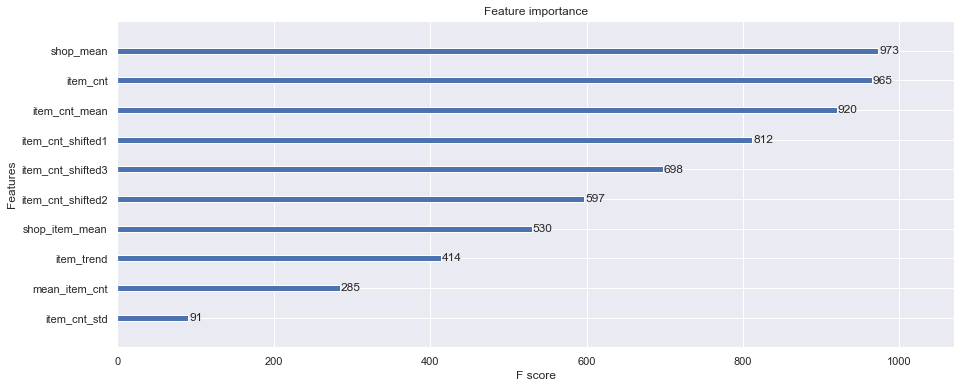

In [110]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

As variáveis que mais contribuiram para o modelo XGBoost foram:
- shop_mean
- item_cnt
- item_cnt_mean
- item_cnt_shifted1

##### Fazendo a predição

In [111]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

Obtendo o RMSE para base de treino e validação

In [112]:
print('Base de Treino RMSE:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Base de Validação RMSE:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

Base de Treino RMSE: 2.7530797303330816
Base de Validação RMSE: 2.694743661790582


#### Random forest


##### Criando base de treino, validação e teste

In [113]:
# Usando apenas parte das variáveis
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']
rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

##### Definindo o modelo e ajustando com a base de treino

In [114]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, Y_train)

RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=-1, random_state=0)

##### Fazendo a predição

In [115]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

Obtendo o RMSE para base de treino e validação

In [116]:
print('Base de Treino RMSE:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
print('Base de Validação RMSE:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Base de Treino RMSE: 1.815974302631889
Base de Validação RMSE: 2.5969103783777956


#### Regressão Linear

##### Criando base de treino, validação e teste

In [117]:
# Usando apenas parte das variáveis
lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

##### Normalizando os dados

In [118]:
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

##### Ajustando o modelo

In [119]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(n_jobs=-1)

##### Fazendo a predição

In [120]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

Obtendo o RMSE para base de treino e validação

In [121]:
print('Base de Treino RMSE:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Base de Validação RMSE:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

Base de Treino RMSE: 2.3163410688798796
Base de Validação RMSE: 2.567977223679676


#### Clusterização com KNN

In [122]:
# Usando apenas parte das variáveis
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']

# Obtendo amostra da base de treino para diminuir o tempo de processamento
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

##### Normalizando os dados

In [123]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

##### Definindo o modelo e ajustando com a base de treino

In [124]:
knn_model = KNeighborsRegressor(n_neighbors=9, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(n_jobs=-1, n_neighbors=9)

##### Fazendo a predição

In [125]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

Obtendo o RMSE para base de treino e validação

In [126]:
print('Base de Treino RMSE:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Base de Validação RMSE:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

Base de Treino RMSE: 1.9383442087526503
Base de Validação RMSE: 3.2477318317315884


##### Criando novos datasets com as predições do primeiro nível.

Será utilizado uma técnica simples de ensembling. As predições dos modelos do primeiro nível servirão como entrada para o ajuste  predição do modelo do segundo nível. Assim, o modelo do segundo nível irá aprender onde aplicar maior peso de acordo com as predições dos modelos do primeiro nivel.

Base que será utilizada como base de treino do modelo de ensembling

In [129]:
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_validation.values
first_level.head(20)

catboost  xgbm  random_forest  linear_regression  knn  label
0       0.67  0.81           0.66               0.56 1.00      0
1       1.28  1.22           0.66               0.05 0.67      0
2       0.07  0.04           0.24               0.05 0.00      0
3       2.00  2.63           0.99               0.05 0.00      4
4       1.71  1.85           2.02               1.64 0.56      1
5       0.61  0.94           0.66               0.05 0.00      1
6       0.60  0.53           0.26               0.05 0.11      0
7       0.03  0.04           0.05               0.05 0.00      1
8       0.38  0.45           0.28               0.05 0.11      0
9       2.35  2.31           1.39               1.27 0.67      2
10      0.61  0.79           0.62               0.05 0.56      0
11      0.60  0.53           0.66               0.05 0.11      0
12      1.28  1.22           0.86               0.05 0.11      0
13      0.61  0.77           0.66               0.05 0.33      0
14      0.10  0.07           0.06               0.05 0.00      0
15      0.60  0.56           0.62               0.05 0.22      1
16      0.38  0.30           0.14               0.05 0.00      0
17      0.61  0.67           0.62               0.05 0.00      0
18      0.50  0.61           0.42               0.56 1.00      0
19      0.49  0.52           0.42               1.17 0.89      0

Base que será utilizada como base de teste do modelo de ensembling


In [130]:
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['xgbm'] = xgb_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

catboost  xgbm  random_forest  linear_regression  knn
0      0.43  0.26           0.83               0.75 0.33
1      0.10  0.00           0.05               0.06 0.00
2      0.19 -0.07           1.27               2.08 1.22
3      0.04  0.00           0.05               0.06 0.00
4      0.10  0.00           0.05               0.06 0.00

### Ensembling


Para combinar as predições de primeiro nível será utilizado o modelo de regressão linear

##### Arquitetura do Ensemble:

Primeiro nível:

- Catboost

- XGBM

- Random forest

- Regressão Linear

- KNN

Segundo nível:
- Regressão Linear

In [131]:
meta_model = LinearRegression(n_jobs=-1)

##### Modelo treinado com as predições do primeiro nível como variáveis preditoras e a varivel resposta da base de validação como variável resposta

In [132]:
# Drop label from dataset.
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_validation)

LinearRegression(n_jobs=-1)

##### Gerando a predição do modelo com ensemble utilizando as predições dos modelos de primeiro nível.

In [133]:
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

##### Métricas do modelo com ensemble na base de validação.

In [137]:
print('Base de Validação RMSE:', np.sqrt(mean_squared_error(ensemble_pred, Y_validation)))

Base de Validação RMSE: 2.4012054625842945


In [135]:
prediction_df = pd.DataFrame(test['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)

ID  item_cnt_month
0   0            0.48
1   1            0.15
2   2            0.51
3   3            0.10
4   4            0.15
5   5            0.53
6   6            0.71
7   7            0.32
8   8            1.98
9   9            0.10